In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout,Input,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Data/train.csv')
dt = pd.read_csv('Data/test.csv')
sf = pd.read_csv('Data/sample_submission.csv')
df.shape, dt.shape, sf.shape

((188533, 13), (125690, 12), (125690, 2))

In [3]:
y = df['price']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [4]:
df.isnull().sum(), dt.isnull().sum()

(id                  0
 brand               0
 model               0
 model_year          0
 milage              0
 fuel_type        5083
 engine              0
 transmission        0
 ext_col             0
 int_col             0
 accident         2452
 clean_title     21419
 price               0
 dtype: int64,
 id                  0
 brand               0
 model               0
 model_year          0
 milage              0
 fuel_type        3383
 engine              0
 transmission        0
 ext_col             0
 int_col             0
 accident         1632
 clean_title     14239
 dtype: int64)

In [5]:
df['accident'] = df['accident'].map({'None reported': 0, 'At least 1 accident or damage reported': 1})
dt['accident'] = dt['accident'].map({'None reported': 0, 'At least 1 accident or damage reported': 1})
def fill_clean_title(row):
    if pd.isna(row['clean_title']):
        return 'missing'
    return row['clean_title']
df['clean_title'] = df.apply(fill_clean_title, axis = 1).map({'Yes': 1, 'missing': 0})
dt['clean_title'] = dt.apply(fill_clean_title, axis = 1).map({'Yes': 1, 'missing': 0})

In [6]:
def extract_data_from_engine(df):
    df = df.copy()
    df['horsepower'] = df['engine'].str.extract(r'(\d+\.\d+)(?=HP)').astype(float)
    df['engine_size'] = df['engine'].str.extract(r'(\d+\.\d+)(?=L)').astype(float)
    df['cylinders'] = df['engine'].str.extract(r'(\d+)\s(Cylinder|V\d|Straight)')[0].astype(float)
    return df
df = extract_data_from_engine(df)
dt = extract_data_from_engine(dt)

In [7]:
def extract_fuel_type(engine_info):
    if pd.isna(engine_info):
        return np.nan
    if 'Gasoline' in engine_info:
        return 'Gasoline'
    elif 'Hybrid' in engine_info:
        return 'Hybrid'
    elif 'Flex Fuel' in engine_info or 'E85' in engine_info:
        return 'Flex Fuel'
    elif 'Diesel' in engine_info:
        return 'Diesel'
    elif 'Electric' in engine_info:
        return 'Electric'
    else:
        return np.nan

df['extracted_fuel_type'] = df['engine'].apply(extract_fuel_type)
df['fuel_type'].fillna(df['extracted_fuel_type'], inplace = True)
df.drop(columns=['extracted_fuel_type'], inplace = True)
dt['extracted_fuel_type'] = dt['engine'].apply(extract_fuel_type)
dt['fuel_type'].fillna(dt['extracted_fuel_type'], inplace = True)
dt.drop(columns=['extracted_fuel_type'], inplace = True)
def feature(df):
    df['brand'] = df['brand'].str.lower()
    current_year = datetime.now().year
    df['Vehicle_Age'] = current_year - df['model_year']
    df['Mileage_per_Year'] = df['milage'] / (df['Vehicle_Age'] + 10e-5)
    luxury_brands = ["mercedes-benz", "bmw", "audi", "porsche", "lexus", "cadillac", "jaguar", "bentley", "genesis", "maserati", "lamborghini", "rolls-royce", "ferrari", "mclaren", "aston", "lotus", "bugatti", "maybach"]
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    
    return df

df = feature(df)
dt = feature(dt)

In [8]:
int_replacements = {
    'Medium Earth Gray': 'Gray',
    'Diesel Gray / Black': 'Gray',
    'Dark Ash': 'Gray',
    'Graphite': 'Gray',
    'Dark Galvanized': 'Charcoal',
    'Light Gray': 'Gray',
    'Ash': 'Gray',
    'Jet Black': 'Black',
    'Global Black': 'Black',
    'Black Onyx': 'Black',
    'Parchment.': 'Beige',
    'Sardar Brown': 'Brown',
    'Black/Gun Metal': 'Black',
    'Charcoal Black': 'Charcoal',
    'Ebony': 'Brown',
    'Ebony Black': 'Black',
    'Carbon Black': 'Black',
    'Obsidian Black': 'Black',
    'Black / Saddle Brown': 'Black',
    'Black/Saddle Brown': 'Black',
    'Black / Brown': 'Black',
    'Saddle Brown': 'Brown',
    'Sand Beige': 'Beige',
    'Camel': 'Beige',
    'Parchment': 'Beige',
    'Macchiato Beige/Black': 'Beige',
    'Silk Beige/Espresso Brown': 'Beige',
    'Canberra Beige': 'Beige',
    'Macchiato': 'Beige',
    'Almond Beige': 'Beige',
    'Grace White': 'White',
    'Ivory / Ebony': 'White',
    'Bianco Polar': 'White',
    'White / Brown': 'White',
    'Platinum': 'White',
    'Cloud': 'Blue',
    'Rift Metallic': 'White',
    'Light Platinum / Jet Black': 'Silver',
    'Billet Clearcoat Metallic': 'Silver',
    'Sakhir Orange': 'Orange',
    'Pimento Red w/Ebony': 'Red',
    'Adrenaline Red': 'Red',
    'Rioja Red': 'Red',
    'Classic Red': 'Red',
    'Magma Red': 'Red',
    'Cobalt Blue': 'Blue',
    'Tempest': 'Blue',
    'Stormy Sea': 'Blue',
    'Navy Pier': 'Blue',
    'Charles Blue': 'Blue',
    'Rhapsody Blue': 'Blue',
    'Kyalami Orange': 'Orange',
    'Sakhir Orange/Black': 'Orange',
    'Dark Gray': 'Gray',
    'Deep Garnet': 'Red',
    'Scarlet Ember': 'Red',
    'Beluga': 'Blue',
    'Chestnut': 'Brown',
    'Boulder': 'Gray',
    'Macchiato/Magmagrey': 'Beige',
    'Medium Stone': 'Gray',
    'BLACK': 'Black',
    'Portland': 'Gray',
    'Sandstone': 'Beige',
    'Slate': 'Gray',
    'Cappuccino': 'Brown',
    'Oyster W/Contrast': 'Beige',
    'Nero Ade': 'Black',
    'Light Titanium': 'Silver',
    'Tan': 'Beige',
    'Brandy': 'Brown',
    'Amber': 'Yellow',
    'Hotspur': 'Blue',
    'Chateau': 'Green',
    'Ice': 'Blue',
    'Blk': 'Black',
    'Mesa': 'Brown',
    'Espresso': 'Brown',
    'Ceramic': 'White',
    'Medium Dark Slate': 'Gray',
    'Graphite w/Gun Metal': 'Gray',
    'Cocoa / Dune': 'Brown',
    'Roast': 'Brown',
    'Hotspur Hide': 'Brown',
    'ORANGE': 'Orange',
    'Walnut': 'Brown',
    'Caramel': 'Beige',
    'Giallo Taurus / Nero Ade': 'Yellow',
    'Medium Pewter': 'Gray',
    'Camel Leather': 'Brown',
    'Anthracite': 'Gray',
    'Mocha': 'Brown',
    'Sahara Tan': 'Beige',
    'Porpoise': 'Beige',
    'Deep Cypress': 'Green',
    'Light Slate': 'Gray',
    'Beluga Hide': 'Black',
    'Tupelo': 'Green',
    'Gideon': 'Beige',
    'Medium Light Camel': 'Beige',
    'Nero': 'Black',
    'Deep Chestnut': 'Red',
    'Dark Auburn': 'Brown',
    'Shale': 'Gray',
    'BEIGE': 'Beige',
    'Linen': 'Beige',
    'WHITE': 'White'
}
ext_replacements = {
    'Blu': 'Blue',
    'BLUE': 'Blue',
    'Glacier': 'Blue',
    'BLU ELEOS': 'Blue',
    'Dark Sapphire': 'Navy',
    'Tangerine': 'Orange',
    'Pumpkin': 'Orange',
    'Clementine': 'Orange',
    'Granite': 'Gray',
    'Go Mango!': 'Yellow',
    'Onyx': 'Black',
    'Gecko Pearlcoat': 'Green',
    'Obsidian': 'Black',
    'Metallic': 'Silver',
    'Grigio Nimbus': 'Silver',
    'Chalk': 'White',
    'Bianco Monocerus': 'White',
    'Verde': 'Green',
    'Dark Graphite Metallic': 'Gray',
    'BLACK': 'Black',
    'Dark Moss': 'Green',
    'Granite Crystal Clearcoat Metallic': 'Gray',
    'Ebony Twilight Metallic': 'Black',
    'Satin Steel Metallic': 'Silver',
    'Magnetic Metallic': 'Gray',
    'Dark Matter Metallic': 'Gray',
    'Dark Ash Metallic': 'Gray',
    'Iridium Metallic': 'Gray',
    'Nightfall Mica': 'Navy',
    'Sandstone Metallic': 'Beige',
    'Rift Metallic': 'White',
    'Billet Clearcoat Metallic': 'Silver',
    'Tan': 'Beige',
    'Ice': 'Blue',
    'Hellayella': 'Yellow',
    'Granite': 'Gray',
    'Yulong': 'White',
    'Blueprint': 'Navy',
    'Arancio Borealis': 'Orange',
    'Hellayella Clearcoat': 'Yellow',
    'Moonlight Cloud': 'Navy',
    'Liquid Platinum': 'Silver',
    'Gun Metallic': 'Gray',
    'Manhattan Noir Metallic': 'Gray',
    'Lavender': 'Purple',
    'Violet': 'Purple',
    'Pink': 'Purple',
    'Mauve': 'Plum',
    'Tempest': 'Blue',
    'Nero Daytona': 'Black',
    'Scarlet Ember': 'Red',
    'Infrared Tintcoat': 'Red',
    'Maximum Steel Metallic': 'Gray',
    'Ember Pearlcoat': 'Brown',
    'Rich Garnet Metallic': 'Brown',
    'Tungsten Metallic': 'Gray',
    'Nero Noctis': 'Black',
    'Platinum Quartz Metallic': 'White',
    'Ruby Flare Pearl': 'Red',
    'Bianco Icarus Metallic': 'White',
    'Stormy Sea': 'Blue',
    'Mountain Air Metallic': 'Blue',
    'Wind Chill Pearl': 'White',
    'Iridescent Pearl Tricoat': 'White',
    'Black Cherry': 'Plum',
    'Black Forest Green': 'Green',
    'Maroon': 'Red',
    'Rosso': 'Red',
    'Rosso Corsa': 'Red',
    'Rosso Mars Metallic': 'Red',
    'Quicksilver Metallic': 'Silver',
    'Designo Magno Matte': 'Gray',
    'Granite Crystal Metallic Clearcoat': 'Gray',
    'Bianco Isis': 'White',
    'Sunset Drift Chromaflair': 'Orange',
    'Ametrin Metallic': 'Plum',
    'GT SILVER': 'Silver',
    'Caviar': 'Black'
}
def standardize_and_extract_colors(df, int_replacements, ext_replacements):
    df['int_col'] = df['int_col'].replace(int_replacements)
    df['ext_col'] = df['ext_col'].replace(ext_replacements)
    df['int_col'] = df['int_col'].str.lower()
    df['ext_col'] = df['ext_col'].str.lower()
    base_colors = [
    'black', 'white', 'gray', 'silver', 'brown', 'red', 'blue', 'green',
    'beige', 'tan', 'orange', 'yellow', 'purple', 'plum', 'charcoal', 
    'ivory', 'camel', 'chestnut', 'pearl', 'linen', 'graphite', 'copper', 
    'slate', 'bronze', 'sand', 'amber', 'macchiato', 'ebony', 'cocoa', 'navy'
    ]
    def find_base_color(text):
        for color in base_colors:
            if color in text:
                return color
        return text
    df['int_col'] = df['int_col'].apply(find_base_color)
    df['ext_col'] = df['ext_col'].apply(find_base_color)
    return df
dt = standardize_and_extract_colors(dt, int_replacements, ext_replacements)
df = standardize_and_extract_colors(df, int_replacements, ext_replacements)

In [9]:
df.isnull().sum(), dt.isnull().sum()

(id                      0
 brand                   0
 model                   0
 model_year              0
 milage                  0
 fuel_type             177
 engine                  0
 transmission            0
 ext_col                 0
 int_col                 0
 accident             2452
 clean_title             0
 price                   0
 horsepower          33259
 engine_size         14214
 cylinders           37855
 Vehicle_Age             0
 Mileage_per_Year        0
 Is_Luxury_Brand         0
 dtype: int64,
 id                      0
 brand                   0
 model                   0
 model_year              0
 milage                  0
 fuel_type             111
 engine                  0
 transmission            0
 ext_col                 0
 int_col                 0
 accident             1632
 clean_title             0
 horsepower          22181
 engine_size          9407
 cylinders           25150
 Vehicle_Age             0
 Mileage_per_Year        0
 Is_Luxury_Br

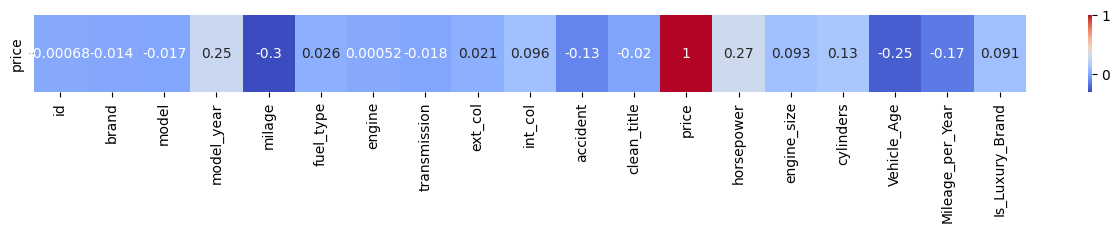

In [10]:
cat_feats = ['brand', 'fuel_type', 'ext_col', 'int_col', 'model']  
numeric_feats = ['milage', 'horsepower', 'engine_size', 'cylinders', 'accident', 'Is_Luxury_Brand', 'Mileage_per_Year', 'Vehicle_Age', 'cylinders'] 
temp=df.dropna()
temp=temp.apply(lambda x : pd.factorize(x)[0] if x.dtype == 'object' else x)
plt.figure(figsize = (16, 1))
sns.heatmap(temp.corr()[12 : 13], annot = True, cmap = 'coolwarm')
plt.show()

In [11]:
df = df.drop(['id', 'engine', 'transmission', 'model_year'], axis = 1)
dt = dt.drop(['id', 'engine', 'transmission', 'model_year'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   brand             188533 non-null  object 
 1   model             188533 non-null  object 
 2   milage            188533 non-null  int64  
 3   fuel_type         188356 non-null  object 
 4   ext_col           188533 non-null  object 
 5   int_col           188533 non-null  object 
 6   accident          186081 non-null  float64
 7   clean_title       188533 non-null  int64  
 8   price             188533 non-null  int64  
 9   horsepower        155274 non-null  float64
 10  engine_size       174319 non-null  float64
 11  cylinders         150678 non-null  float64
 12  Vehicle_Age       188533 non-null  int64  
 13  Mileage_per_Year  188533 non-null  float64
 14  Is_Luxury_Brand   188533 non-null  int64  
dtypes: float64(5), int64(5), object(5)
memory usage: 21.6+ MB


In [12]:
def cleaning(df, cat_feats, threshold = 15):
    for i in cat_feats:
        if df[i].dtype.name == 'category':
            if 'missing' not in df[i].cat.categories:
                df[i] = df[i].cat.add_categories('missing')
            if 'noise' not in df[i].cat.categories:
                df[i] = df[i].cat.add_categories('noise')
        else:
            df[i] = df[i].astype('category')
            df[i] = df[i].cat.add_categories(['missing', 'noise'])
        df[i] = df[i].fillna('missing')
        count = df[i].value_counts(dropna = False)
        less_freq = count[count < threshold].index
        df[i] = df[i].apply(lambda x: 'noise' if x in less_freq else x)
    return df
df = cleaning(df, cat_feats)
dt = cleaning(dt, cat_feats) 
def fillna(df, c):
    df[c]=df[c].fillna(df[c].mode()[0])
for c in numeric_feats:
    fillna(df, c)
    fillna(dt, c)
for col in cat_feats :
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    dt[col] = le.fit_transform(dt[col])  
df.isnull().sum(), dt.isnull().sum()

(brand               0
 model               0
 milage              0
 fuel_type           0
 ext_col             0
 int_col             0
 accident            0
 clean_title         0
 price               0
 horsepower          0
 engine_size         0
 cylinders           0
 Vehicle_Age         0
 Mileage_per_Year    0
 Is_Luxury_Brand     0
 dtype: int64,
 brand               0
 model               0
 milage              0
 fuel_type           0
 ext_col             0
 int_col             0
 accident            0
 clean_title         0
 horsepower          0
 engine_size         0
 cylinders           0
 Vehicle_Age         0
 Mileage_per_Year    0
 Is_Luxury_Brand     0
 dtype: int64)

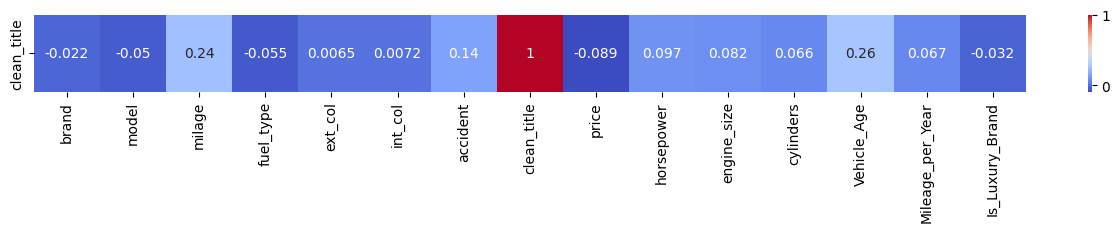

In [13]:
temp = df.dropna()
temp = temp.apply(lambda x : pd.factorize(x)[0] if x.dtype == 'object' else x)
plt.figure(figsize = (16, 1))
sns.heatmap(temp.corr()[7 : 8], annot = True, cmap = 'coolwarm')
plt.show()

In [14]:
X = df.drop(['price'], axis = 1)
X.shape, y.shape

((188533, 14), (188533,))

In [15]:
from sklearn.preprocessing import MinMaxScaler
numerical_columns = ['brand', 'milage', 'fuel_type', 'ext_col', 'int_col', 'accident',
                     'clean_title', 'horsepower', 'engine_size', 'cylinders',
                     'Vehicle_Age', 'Mileage_per_Year', 'Is_Luxury_Brand']
scaler = MinMaxScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
dt[numerical_columns] = scaler.transform(dt[numerical_columns])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.17, random_state = 8)

Epoch 1/120
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 8209019392.0000 - val_loss: 8253794304.0000 - learning_rate: 0.0010
Epoch 2/120
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8272022016.0000 - val_loss: 8125724160.0000 - learning_rate: 0.0010
Epoch 3/120
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8490738176.0000 - val_loss: 7952977920.0000 - learning_rate: 0.0010
Epoch 4/120
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 8561570304.0000 - val_loss: 8220480000.0000 - learning_rate: 0.0010
Epoch 5/120
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7327148032.0000 - val_loss: 7224194560.0000 - learning_rate: 0.0010
Epoch 6/120
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 7386715136.0000 - val_loss: 7024678400.0000 - learning_rate: 0.0010
Epoch 7/120
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7364454400.0000 - val_loss: 7407414272.0000 - learning_rate: 0.0010
Epoch 8/120
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7198253568.0000 - va

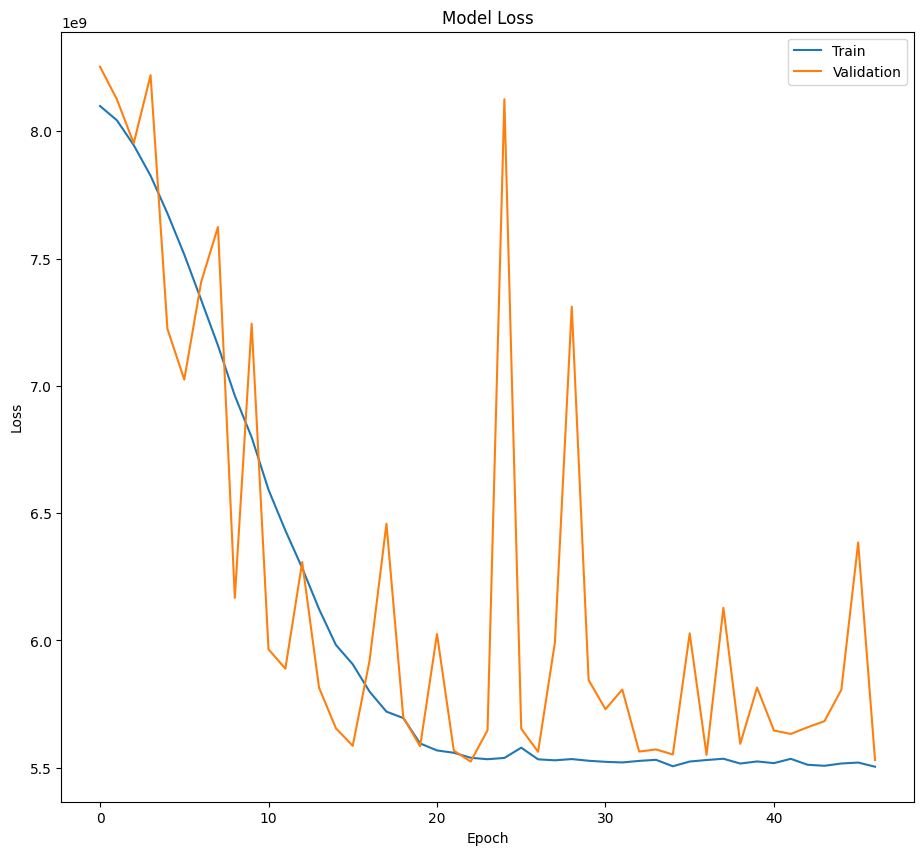

In [16]:
model = Sequential([
    Input(shape = (X_train.shape[1],)),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.13),
    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'linear')  
])
model.compile(loss = 'mean_squared_error', optimizer = Adam(learning_rate = 0.001))
es = EarlyStopping(monitor = 'val_loss', patience = 24, restore_best_weights = True)
lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 24, min_lr = 1e-6)
history = model.fit(X_train, y_train, epochs = 120, batch_size = 128, validation_data = (X_val, y_val), callbacks = [es, lr])
plt.figure(figsize=(11, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [17]:
from sklearn.metrics import root_mean_squared_error as rmse
train_error = rmse(y_train, model.predict(X_train))
val_error = rmse(y_val, model.predict(X_val))

4891/4891 ━━━━━━━━━━━━━━━━━━━━ 4s 816us/step
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step


In [18]:
print("Train RMSE: ", train_error)
print("Validation RMSE: ", val_error)

Train RMSE:  73771.9140625
Validation RMSE:  74325.8125


In [19]:
y_pred = model.predict(dt)
sf.set_index('id', inplace = True)
sf['price'] = y_pred
sf.to_csv('Submission.csv')

3928/3928 ━━━━━━━━━━━━━━━━━━━━ 3s 852us/step
